In [1]:
import pickle
import os

from datetime import datetime
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OrdinalEncoder
        
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler

In [13]:
ts= pd.read_csv('../../../data/ts_top100_prediction.csv')
print(ts.shape)
ts.sample(1)

(1739323, 6)


,date,id,item,sales,income,event
1424483,2015-06-15,HOME_&_GARDEN_1_469_NYC_1,HOME_&_GARDEN_1_469,0,0.0,0


In [14]:
ts['date']= pd.to_datetime(ts['date'], format='%Y-%m-%d')
ts['weekday'] = ts['date'].dt.day_name()
ts.head(1)

,date,id,item,sales,income,event,weekday
0,2011-01-29,ACCESORIES_1_108_NYC_1,ACCESORIES_1_108,4,64.4784,0,Saturday


In [15]:
ts = ts[(ts['id']=='SUPERMARKET_3_586_BOS_1')]

In [16]:
ts_predict = ts[['date','sales','weekday','event']]

In [5]:
ts_predict

,date,sales,weekday,event
285,2011-01-29,53,Saturday,0
861,2011-01-30,46,Sunday,0
1437,2011-01-31,42,Monday,0
2013,2011-02-01,45,Tuesday,0
2589,2011-02-02,28,Wednesday,0
...,...,...,...,...
1734803,2016-04-20,45,Wednesday,0
1735803,2016-04-21,59,Thursday,0
1736803,2016-04-22,50,Friday,0
1737803,2016-04-23,56,Saturday,0


In [18]:
ts_predict = pd.get_dummies(data=ts_predict, columns=['weekday'], dtype=int)

In [19]:
ts_predict.sort_values('date', ascending=True, inplace=True)

In [20]:
ts_predict.set_index('date', inplace=True)

In [21]:
ts_predict.tail(1)

,sales,event,weekday_Friday,weekday_Monday,weekday_Saturday,weekday_Sunday,weekday_Thursday,weekday_Tuesday,weekday_Wednesday
date,,,,,,,,,
2016-04-24,58,0,0,0,0,1,0,0,0


In [22]:
ts_predict1 = ts_predict.copy()

In [23]:
ts_predict1 = ts_predict[['sales']]
ts_predict1.head(1)

,sales
date,
2011-01-29,53


In [24]:
ts_predict1 = ts_predict1.asfreq('D')

Train dates : 2011-01-29 00:00:00 --- 2016-03-25 00:00:00  (n=1883)
Test dates  : 2016-03-26 00:00:00 --- 2016-04-24 00:00:00  (n=30)


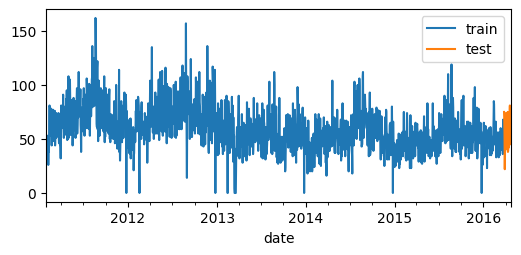

In [25]:
steps = 30
data_train = ts_predict1[:-steps]
data_test  = ts_predict1[-steps:]
print(
    f"Train dates : {data_train.index.min()} --- "
    f"{data_train.index.max()}  (n={len(data_train)})"
)
print(
    f"Test dates  : {data_test.index.min()} --- "
    f"{data_test.index.max()}  (n={len(data_test)})"
)

fig, ax = plt.subplots(figsize=(6, 2.5))
data_train['sales'].plot(ax=ax, label='train')
data_test['sales'].plot(ax=ax, label='test')
ax.legend();

In [26]:
import skforecast
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregCustom import ForecasterAutoregCustom
from skforecast.ForecasterAutoregDirect import ForecasterAutoregDirect
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster
from skforecast.utils import save_forecaster
from skforecast.utils import load_forecaster
import shap

c:\Users\harol\Nuclio\DS-MARKET-TFM\env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Sin Hiperparámetros

In [27]:
forecaster = ForecasterAutoreg(
                 regressor = RandomForestRegressor(random_state=123),
                 lags      = 14
             )
forecaster.fit(y=data_train['sales'])

In [28]:
predictions = forecaster.predict(steps=30)
# Test error
# ==============================================================================
error_mse = mean_squared_error(
                y_true = data_test['sales'],
                y_pred = predictions
            )
print(f"Test error (MSE): {error_mse}")

Test error (MSE): 275.40478333333334


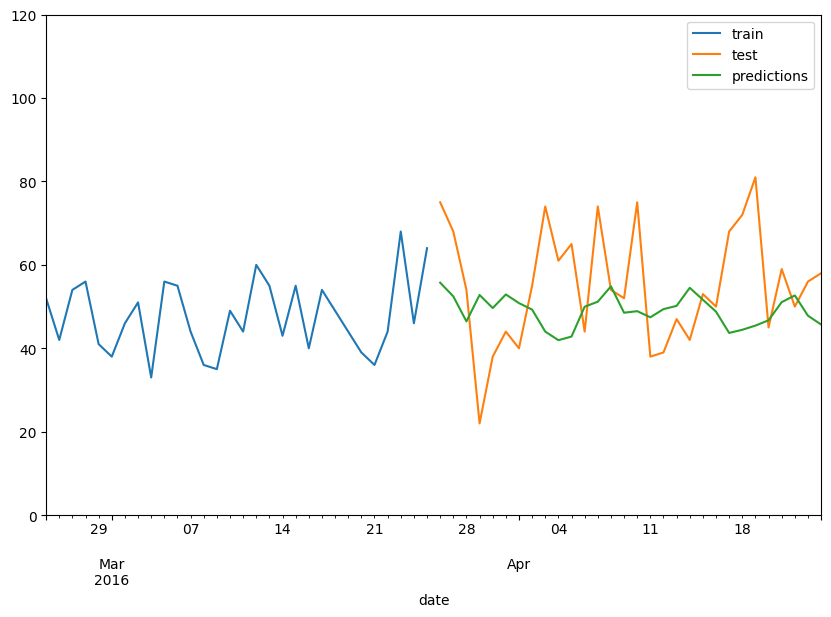

In [29]:
fig, ax = plt.subplots(figsize=(10, 6.5))
data_train['sales'][-30:].plot(ax=ax, label='train')
data_test['sales'][-30:].plot(ax=ax, label='test')
ax.set_ylim(0,120)
predictions.plot(ax=ax, label='predictions')
ax.legend();

## CON HIPERPARÁMETROS

In [49]:
# Hyperparameters: grid search
# ==============================================================================
steps = 30
forecaster = ForecasterAutoreg(
                 regressor = RandomForestRegressor(random_state=123),
                 lags      = 7 # This value will be replaced in the grid search
             )

# Candidate values for lags
lags_grid = [3,4,5,7,8,10, 14, 20]

# Candidate values for regressor's hyperparameters
param_grid = {
    'n_estimators': [100, 250],
    'max_depth': [3, 8]
}

results_grid = grid_search_forecaster(
                   forecaster         = forecaster,
                   y                  = data_train['sales'],
                   param_grid         = param_grid,
                   lags_grid          = lags_grid,
                   steps              = steps,
                   metric             = 'mean_squared_error',
                   initial_train_size = int(len(data_train)*0.5),
                   fixed_train_size   = False,
                   refit              = False,
                   skip_folds         = None,
                   return_best        = True,
                   n_jobs             = 'auto',
                   verbose            = False
               )

Number of models compared: 32.


lags grid: 100%|██████████| 8/8 [05:21<00:00, 40.24s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20] 
  Parameters: {'max_depth': 8, 'n_estimators': 100}
  Backtesting metric: 1329.8642308184685



/home/haroldavis/Projects/DS-MARKET-TFM/env/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:307: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(


In [30]:
regressor = RandomForestRegressor(n_estimators=100, max_depth=8, random_state=123)
forecaster = ForecasterAutoreg(
                 regressor = regressor,
                 lags      = 12
             )
forecaster.fit(y=data_train['sales'])

In [31]:
predictions = forecaster.predict(steps=30)
# Test error
# ==============================================================================
error_mse = mean_squared_error(
                y_true = data_test['sales'],
                y_pred = predictions
            )
print(f"Test error (MSE): {error_mse}")

Test error (MSE): 238.7978958896629


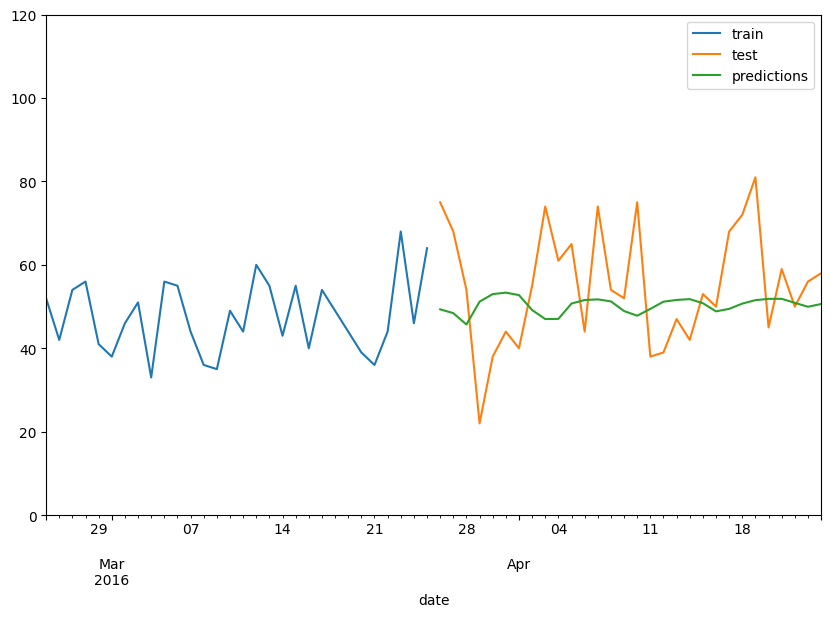

In [32]:
fig, ax = plt.subplots(figsize=(10, 6.5))
data_train['sales'][-30:].plot(ax=ax, label='train')
data_test['sales'][-30:].plot(ax=ax, label='test')
ax.set_ylim(0,120)
predictions.plot(ax=ax, label='predictions')
ax.legend();

## Con exógenas

In [34]:
data_test = ts_predict.copy()

In [35]:
ts_predict.head(1)

,sales,event,weekday_Friday,weekday_Monday,weekday_Saturday,weekday_Sunday,weekday_Thursday,weekday_Tuesday,weekday_Wednesday
date,,,,,,,,,
2011-01-29,53,0,0,0,1,0,0,0,0


In [36]:
ts_predict.sort_values('date', ascending=True)
ts_predict.head(1)

,sales,event,weekday_Friday,weekday_Monday,weekday_Saturday,weekday_Sunday,weekday_Thursday,weekday_Tuesday,weekday_Wednesday
date,,,,,,,,,
2011-01-29,53,0,0,0,1,0,0,0,0


In [28]:
# # Definir el punto de división (80% de los datos para entrenamiento)
# train_size = -30

# # Dividir la serie objetivo en train y test
# y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]

# # Dividir las variables exógenas en train y test
# exog_train, exog_test = exog.iloc[:train_size], exog.iloc[train_size:]

In [37]:
y = ts_predict['sales']
y = y.asfreq('D')

In [38]:
exog = ts_predict[['event', 'weekday_Friday', 'weekday_Monday','weekday_Saturday', 'weekday_Sunday','weekday_Thursday','weekday_Tuesday','weekday_Wednesday']]
exog = exog.asfreq('D')

In [39]:
y_train, y_test= y[:-30], y[-30:]
exog_train, exog_test = exog[:-30], exog[-30:]

In [40]:
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from sklearn.ensemble import RandomForestRegressor

forecaster = ForecasterAutoreg(
    regressor=RandomForestRegressor(),
    lags=12 
)

forecaster.fit(y=y_train, exog=exog_train)

In [41]:
# Hacer predicciones para el tamaño del conjunto de prueba
steps = len(y_test)  # Número de pasos igual al tamaño de y_test
predictions = forecaster.predict(steps=steps, exog=exog_test)

# Evaluar el modelo comparando las predicciones con los valores reales
from sklearn.metrics import mean_squared_error

mse = mean_squared_error(y_test, predictions)
print(f'Mean Squared Error: {mse}')

Mean Squared Error: 168.77386666666663


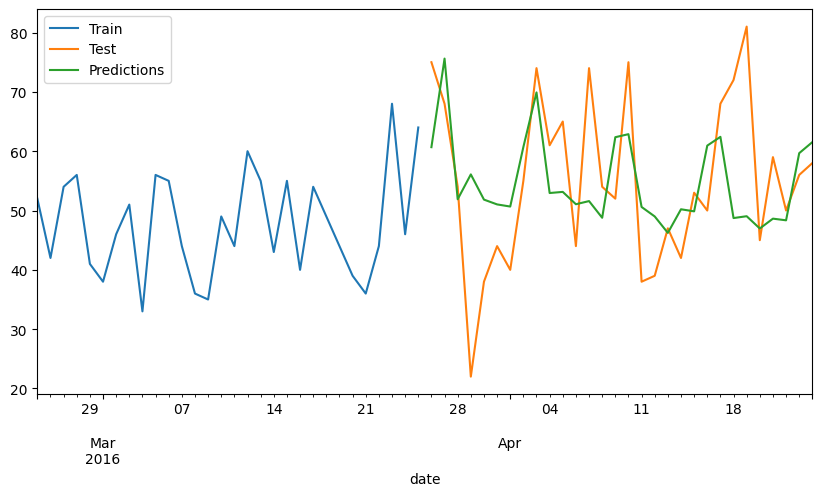

In [43]:
fig, ax = plt.subplots(figsize=(10, 5))
y_train[-30:].plot(ax=ax, label='Train')
y_test[-30:].plot(ax=ax, label='Test')
predictions.plot(ax=ax, label='Predictions')
ax.legend()
plt.show()

### CON HIPERPARAMETROS - EXOGENA

In [64]:
forecaster = ForecasterAutoreg(
    regressor=RandomForestRegressor(random_state=42),
    lags=5  
)

param_grid = {
    'n_estimators': [50, 100, 200], 
    'max_depth': [None, 5, 10],  
    'min_samples_split': [2, 5], 
    'min_samples_leaf': [1, 2],  
}

lags_grid = [7, 14, 21, 30]

results_grid = grid_search_forecaster(
    forecaster=forecaster,
    y=y_train,  
    exog=exog_train,  
    param_grid=param_grid,  
    lags_grid=lags_grid,
    steps=7,  
    metric='mean_squared_error', 
    initial_train_size=len(y_train) - 30,  
    refit=True,  
    return_best=True, 
    verbose=True
)

# Mostrar los mejores parámetros y el error
print(f"Mejores parámetros: {results_grid}")
print(f"Mejor RMSE: {results_grid['mean_squared_error'].min()}")


Number of models compared: 144.


lags grid:   0%|          | 0/4 [00:00<?, ?it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 1853
Number of observations used for backtesting: 30
    Number of folds: 5
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0
    Last fold only includes 2 observations.

Fold: 0
    Training:   2011-01-29 00:00:00 -- 2016-02-24 00:00:00  (n=1853)
    Validation: 2016-02-25 00:00:00 -- 2016-03-02 00:00:00  (n=7)
Fold: 1
    Training:   2011-02-05 00:00:00 -- 2016-03-02 00:00:00  (n=1853)
    Validation: 2016-03-03 00:00:00 -- 2016-03-09 00:00:00  (n=7)
Fold: 2
    Training:   2011-02-12 00:00:00 -- 2016-03-09 00:00:00  (n=1853)
    Validation: 2016-03-10 00:00:00 -- 2016-03-16 00:00:00  (n=7)
Fold: 3
    Training:   2011-02-19 00:00:00 -- 2016-03-16 00:00:00  (n=1853)
    Validation: 2016-03-17 00:00:00 -- 2016-03-23 00:00:00  (n=7)
Fold: 4
    Training:   2011-02-26 00:00:00

Information of backtesting process
----------------------------------
Number of observations used for initial training: 1853
Number of observations used for backtesting: 30
    Number of folds: 5
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0
    Last fold only includes 2 observations.

Fold: 0
    Training:   2011-01-29 00:00:00 -- 2016-02-24 00:00:00  (n=1853)
    Validation: 2016-02-25 00:00:00 -- 2016-03-02 00:00:00  (n=7)
Fold: 1
    Training:   2011-02-05 00:00:00 -- 2016-03-02 00:00:00  (n=1853)
    Validation: 2016-03-03 00:00:00 -- 2016-03-09 00:00:00  (n=7)
Fold: 2
    Training:   2011-02-12 00:00:00 -- 2016-03-09 00:00:00  (n=1853)
    Validation: 2016-03-10 00:00:00 -- 2016-03-16 00:00:00  (n=7)
Fold: 3
    Training:   2011-02-19 00:00:00 -- 2016-03-16 00:00:00  (n=1853)
    Validation: 2016-03-17 00:00:00 -- 2016-03-23 00:00:00  (n=7)
Fold: 4
    Training:   2011-02-26 00:00:00

Information of backtesting process
----------------------------------
Number of observations used for initial training: 1853
Number of observations used for backtesting: 30
    Number of folds: 5
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0
    Last fold only includes 2 observations.

Fold: 0
    Training:   2011-01-29 00:00:00 -- 2016-02-24 00:00:00  (n=1853)
    Validation: 2016-02-25 00:00:00 -- 2016-03-02 00:00:00  (n=7)
Fold: 1
    Training:   2011-02-05 00:00:00 -- 2016-03-02 00:00:00  (n=1853)
    Validation: 2016-03-03 00:00:00 -- 2016-03-09 00:00:00  (n=7)
Fold: 2
    Training:   2011-02-12 00:00:00 -- 2016-03-09 00:00:00  (n=1853)
    Validation: 2016-03-10 00:00:00 -- 2016-03-16 00:00:00  (n=7)
Fold: 3
    Training:   2011-02-19 00:00:00 -- 2016-03-16 00:00:00  (n=1853)
    Validation: 2016-03-17 00:00:00 -- 2016-03-23 00:00:00  (n=7)
Fold: 4
    Training:   2011-02-26 00:00:00

Information of backtesting process
----------------------------------
Number of observations used for initial training: 1853
Number of observations used for backtesting: 30
    Number of folds: 5
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0
    Last fold only includes 2 observations.

Fold: 0
    Training:   2011-01-29 00:00:00 -- 2016-02-24 00:00:00  (n=1853)
    Validation: 2016-02-25 00:00:00 -- 2016-03-02 00:00:00  (n=7)
Fold: 1
    Training:   2011-02-05 00:00:00 -- 2016-03-02 00:00:00  (n=1853)
    Validation: 2016-03-03 00:00:00 -- 2016-03-09 00:00:00  (n=7)
Fold: 2
    Training:   2011-02-12 00:00:00 -- 2016-03-09 00:00:00  (n=1853)
    Validation: 2016-03-10 00:00:00 -- 2016-03-16 00:00:00  (n=7)
Fold: 3
    Training:   2011-02-19 00:00:00 -- 2016-03-16 00:00:00  (n=1853)
    Validation: 2016-03-17 00:00:00 -- 2016-03-23 00:00:00  (n=7)
Fold: 4
    Training:   2011-02-26 00:00:00

Information of backtesting process
----------------------------------
Number of observations used for initial training: 1853
Number of observations used for backtesting: 30
    Number of folds: 5
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0
    Last fold only includes 2 observations.

Fold: 0
    Training:   2011-01-29 00:00:00 -- 2016-02-24 00:00:00  (n=1853)
    Validation: 2016-02-25 00:00:00 -- 2016-03-02 00:00:00  (n=7)
Fold: 1
    Training:   2011-02-05 00:00:00 -- 2016-03-02 00:00:00  (n=1853)
    Validation: 2016-03-03 00:00:00 -- 2016-03-09 00:00:00  (n=7)
Fold: 2
    Training:   2011-02-12 00:00:00 -- 2016-03-09 00:00:00  (n=1853)
    Validation: 2016-03-10 00:00:00 -- 2016-03-16 00:00:00  (n=7)
Fold: 3
    Training:   2011-02-19 00:00:00 -- 2016-03-16 00:00:00  (n=1853)
    Validation: 2016-03-17 00:00:00 -- 2016-03-23 00:00:00  (n=7)
Fold: 4
    Training:   2011-02-26 00:00:00

Information of backtesting process
----------------------------------
Number of observations used for initial training: 1853
Number of observations used for backtesting: 30
    Number of folds: 5
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0
    Last fold only includes 2 observations.

Fold: 0
    Training:   2011-01-29 00:00:00 -- 2016-02-24 00:00:00  (n=1853)
    Validation: 2016-02-25 00:00:00 -- 2016-03-02 00:00:00  (n=7)
Fold: 1
    Training:   2011-02-05 00:00:00 -- 2016-03-02 00:00:00  (n=1853)
    Validation: 2016-03-03 00:00:00 -- 2016-03-09 00:00:00  (n=7)
Fold: 2
    Training:   2011-02-12 00:00:00 -- 2016-03-09 00:00:00  (n=1853)
    Validation: 2016-03-10 00:00:00 -- 2016-03-16 00:00:00  (n=7)
Fold: 3
    Training:   2011-02-19 00:00:00 -- 2016-03-16 00:00:00  (n=1853)
    Validation: 2016-03-17 00:00:00 -- 2016-03-23 00:00:00  (n=7)
Fold: 4
    Training:   2011-02-26 00:00:00

Information of backtesting process
----------------------------------
Number of observations used for initial training: 1853
Number of observations used for backtesting: 30
    Number of folds: 5
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0
    Last fold only includes 2 observations.

Fold: 0
    Training:   2011-01-29 00:00:00 -- 2016-02-24 00:00:00  (n=1853)
    Validation: 2016-02-25 00:00:00 -- 2016-03-02 00:00:00  (n=7)
Fold: 1
    Training:   2011-02-05 00:00:00 -- 2016-03-02 00:00:00  (n=1853)
    Validation: 2016-03-03 00:00:00 -- 2016-03-09 00:00:00  (n=7)
Fold: 2
    Training:   2011-02-12 00:00:00 -- 2016-03-09 00:00:00  (n=1853)
    Validation: 2016-03-10 00:00:00 -- 2016-03-16 00:00:00  (n=7)
Fold: 3
    Training:   2011-02-19 00:00:00 -- 2016-03-16 00:00:00  (n=1853)
    Validation: 2016-03-17 00:00:00 -- 2016-03-23 00:00:00  (n=7)
Fold: 4
    Training:   2011-02-26 00:00:00

Information of backtesting process
----------------------------------
Number of observations used for initial training: 1853
Number of observations used for backtesting: 30
    Number of folds: 5
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0
    Last fold only includes 2 observations.

Fold: 0
    Training:   2011-01-29 00:00:00 -- 2016-02-24 00:00:00  (n=1853)
    Validation: 2016-02-25 00:00:00 -- 2016-03-02 00:00:00  (n=7)
Fold: 1
    Training:   2011-02-05 00:00:00 -- 2016-03-02 00:00:00  (n=1853)
    Validation: 2016-03-03 00:00:00 -- 2016-03-09 00:00:00  (n=7)
Fold: 2
    Training:   2011-02-12 00:00:00 -- 2016-03-09 00:00:00  (n=1853)
    Validation: 2016-03-10 00:00:00 -- 2016-03-16 00:00:00  (n=7)
Fold: 3
    Training:   2011-02-19 00:00:00 -- 2016-03-16 00:00:00  (n=1853)
    Validation: 2016-03-17 00:00:00 -- 2016-03-23 00:00:00  (n=7)
Fold: 4
    Training:   2011-02-26 00:00:00

Information of backtesting process
----------------------------------
Number of observations used for initial training: 1853
Number of observations used for backtesting: 30
    Number of folds: 5
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0
    Last fold only includes 2 observations.

Fold: 0
    Training:   2011-01-29 00:00:00 -- 2016-02-24 00:00:00  (n=1853)
    Validation: 2016-02-25 00:00:00 -- 2016-03-02 00:00:00  (n=7)
Fold: 1
    Training:   2011-02-05 00:00:00 -- 2016-03-02 00:00:00  (n=1853)
    Validation: 2016-03-03 00:00:00 -- 2016-03-09 00:00:00  (n=7)
Fold: 2
    Training:   2011-02-12 00:00:00 -- 2016-03-09 00:00:00  (n=1853)
    Validation: 2016-03-10 00:00:00 -- 2016-03-16 00:00:00  (n=7)
Fold: 3
    Training:   2011-02-19 00:00:00 -- 2016-03-16 00:00:00  (n=1853)
    Validation: 2016-03-17 00:00:00 -- 2016-03-23 00:00:00  (n=7)
Fold: 4
    Training:   2011-02-26 00:00:00

Information of backtesting process
----------------------------------
Number of observations used for initial training: 1853
Number of observations used for backtesting: 30
    Number of folds: 5
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0
    Last fold only includes 2 observations.

Fold: 0
    Training:   2011-01-29 00:00:00 -- 2016-02-24 00:00:00  (n=1853)
    Validation: 2016-02-25 00:00:00 -- 2016-03-02 00:00:00  (n=7)
Fold: 1
    Training:   2011-02-05 00:00:00 -- 2016-03-02 00:00:00  (n=1853)
    Validation: 2016-03-03 00:00:00 -- 2016-03-09 00:00:00  (n=7)
Fold: 2
    Training:   2011-02-12 00:00:00 -- 2016-03-09 00:00:00  (n=1853)
    Validation: 2016-03-10 00:00:00 -- 2016-03-16 00:00:00  (n=7)
Fold: 3
    Training:   2011-02-19 00:00:00 -- 2016-03-16 00:00:00  (n=1853)
    Validation: 2016-03-17 00:00:00 -- 2016-03-23 00:00:00  (n=7)
Fold: 4
    Training:   2011-02-26 00:00:00

Information of backtesting process
----------------------------------
Number of observations used for initial training: 1853
Number of observations used for backtesting: 30
    Number of folds: 5
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0
    Last fold only includes 2 observations.

Fold: 0
    Training:   2011-01-29 00:00:00 -- 2016-02-24 00:00:00  (n=1853)
    Validation: 2016-02-25 00:00:00 -- 2016-03-02 00:00:00  (n=7)
Fold: 1
    Training:   2011-02-05 00:00:00 -- 2016-03-02 00:00:00  (n=1853)
    Validation: 2016-03-03 00:00:00 -- 2016-03-09 00:00:00  (n=7)
Fold: 2
    Training:   2011-02-12 00:00:00 -- 2016-03-09 00:00:00  (n=1853)
    Validation: 2016-03-10 00:00:00 -- 2016-03-16 00:00:00  (n=7)
Fold: 3
    Training:   2011-02-19 00:00:00 -- 2016-03-16 00:00:00  (n=1853)
    Validation: 2016-03-17 00:00:00 -- 2016-03-23 00:00:00  (n=7)
Fold: 4
    Training:   2011-02-26 00:00:00

Information of backtesting process
----------------------------------
Number of observations used for initial training: 1853
Number of observations used for backtesting: 30
    Number of folds: 5
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0
    Last fold only includes 2 observations.

Fold: 0
    Training:   2011-01-29 00:00:00 -- 2016-02-24 00:00:00  (n=1853)
    Validation: 2016-02-25 00:00:00 -- 2016-03-02 00:00:00  (n=7)
Fold: 1
    Training:   2011-02-05 00:00:00 -- 2016-03-02 00:00:00  (n=1853)
    Validation: 2016-03-03 00:00:00 -- 2016-03-09 00:00:00  (n=7)
Fold: 2
    Training:   2011-02-12 00:00:00 -- 2016-03-09 00:00:00  (n=1853)
    Validation: 2016-03-10 00:00:00 -- 2016-03-16 00:00:00  (n=7)
Fold: 3
    Training:   2011-02-19 00:00:00 -- 2016-03-16 00:00:00  (n=1853)
    Validation: 2016-03-17 00:00:00 -- 2016-03-23 00:00:00  (n=7)
Fold: 4
    Training:   2011-02-26 00:00:00

Information of backtesting process
----------------------------------
Number of observations used for initial training: 1853
Number of observations used for backtesting: 30
    Number of folds: 5
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0
    Last fold only includes 2 observations.

Fold: 0
    Training:   2011-01-29 00:00:00 -- 2016-02-24 00:00:00  (n=1853)
    Validation: 2016-02-25 00:00:00 -- 2016-03-02 00:00:00  (n=7)
Fold: 1
    Training:   2011-02-05 00:00:00 -- 2016-03-02 00:00:00  (n=1853)
    Validation: 2016-03-03 00:00:00 -- 2016-03-09 00:00:00  (n=7)
Fold: 2
    Training:   2011-02-12 00:00:00 -- 2016-03-09 00:00:00  (n=1853)
    Validation: 2016-03-10 00:00:00 -- 2016-03-16 00:00:00  (n=7)
Fold: 3
    Training:   2011-02-19 00:00:00 -- 2016-03-16 00:00:00  (n=1853)
    Validation: 2016-03-17 00:00:00 -- 2016-03-23 00:00:00  (n=7)
Fold: 4
    Training:   2011-02-26 00:00:00

Information of backtesting process
----------------------------------
Number of observations used for initial training: 1853
Number of observations used for backtesting: 30
    Number of folds: 5
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0
    Last fold only includes 2 observations.

Fold: 0
    Training:   2011-01-29 00:00:00 -- 2016-02-24 00:00:00  (n=1853)
    Validation: 2016-02-25 00:00:00 -- 2016-03-02 00:00:00  (n=7)
Fold: 1
    Training:   2011-02-05 00:00:00 -- 2016-03-02 00:00:00  (n=1853)
    Validation: 2016-03-03 00:00:00 -- 2016-03-09 00:00:00  (n=7)
Fold: 2
    Training:   2011-02-12 00:00:00 -- 2016-03-09 00:00:00  (n=1853)
    Validation: 2016-03-10 00:00:00 -- 2016-03-16 00:00:00  (n=7)
Fold: 3
    Training:   2011-02-19 00:00:00 -- 2016-03-16 00:00:00  (n=1853)
    Validation: 2016-03-17 00:00:00 -- 2016-03-23 00:00:00  (n=7)
Fold: 4
    Training:   2011-02-26 00:00:00

Information of backtesting process
----------------------------------
Number of observations used for initial training: 1853
Number of observations used for backtesting: 30
    Number of folds: 5
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0
    Last fold only includes 2 observations.

Fold: 0
    Training:   2011-01-29 00:00:00 -- 2016-02-24 00:00:00  (n=1853)
    Validation: 2016-02-25 00:00:00 -- 2016-03-02 00:00:00  (n=7)
Fold: 1
    Training:   2011-02-05 00:00:00 -- 2016-03-02 00:00:00  (n=1853)
    Validation: 2016-03-03 00:00:00 -- 2016-03-09 00:00:00  (n=7)
Fold: 2
    Training:   2011-02-12 00:00:00 -- 2016-03-09 00:00:00  (n=1853)
    Validation: 2016-03-10 00:00:00 -- 2016-03-16 00:00:00  (n=7)
Fold: 3
    Training:   2011-02-19 00:00:00 -- 2016-03-16 00:00:00  (n=1853)
    Validation: 2016-03-17 00:00:00 -- 2016-03-23 00:00:00  (n=7)
Fold: 4
    Training:   2011-02-26 00:00:00

Information of backtesting process
----------------------------------
Number of observations used for initial training: 1853
Number of observations used for backtesting: 30
    Number of folds: 5
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0
    Last fold only includes 2 observations.

Fold: 0
    Training:   2011-01-29 00:00:00 -- 2016-02-24 00:00:00  (n=1853)
    Validation: 2016-02-25 00:00:00 -- 2016-03-02 00:00:00  (n=7)
Fold: 1
    Training:   2011-02-05 00:00:00 -- 2016-03-02 00:00:00  (n=1853)
    Validation: 2016-03-03 00:00:00 -- 2016-03-09 00:00:00  (n=7)
Fold: 2
    Training:   2011-02-12 00:00:00 -- 2016-03-09 00:00:00  (n=1853)
    Validation: 2016-03-10 00:00:00 -- 2016-03-16 00:00:00  (n=7)
Fold: 3
    Training:   2011-02-19 00:00:00 -- 2016-03-16 00:00:00  (n=1853)
    Validation: 2016-03-17 00:00:00 -- 2016-03-23 00:00:00  (n=7)
Fold: 4
    Training:   2011-02-26 00:00:00

Information of backtesting process
----------------------------------
Number of observations used for initial training: 1853
Number of observations used for backtesting: 30
    Number of folds: 5
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0
    Last fold only includes 2 observations.

Fold: 0
    Training:   2011-01-29 00:00:00 -- 2016-02-24 00:00:00  (n=1853)
    Validation: 2016-02-25 00:00:00 -- 2016-03-02 00:00:00  (n=7)
Fold: 1
    Training:   2011-02-05 00:00:00 -- 2016-03-02 00:00:00  (n=1853)
    Validation: 2016-03-03 00:00:00 -- 2016-03-09 00:00:00  (n=7)
Fold: 2
    Training:   2011-02-12 00:00:00 -- 2016-03-09 00:00:00  (n=1853)
    Validation: 2016-03-10 00:00:00 -- 2016-03-16 00:00:00  (n=7)
Fold: 3
    Training:   2011-02-19 00:00:00 -- 2016-03-16 00:00:00  (n=1853)
    Validation: 2016-03-17 00:00:00 -- 2016-03-23 00:00:00  (n=7)
Fold: 4
    Training:   2011-02-26 00:00:00

Information of backtesting process
----------------------------------
Number of observations used for initial training: 1853
Number of observations used for backtesting: 30
    Number of folds: 5
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0
    Last fold only includes 2 observations.

Fold: 0
    Training:   2011-01-29 00:00:00 -- 2016-02-24 00:00:00  (n=1853)
    Validation: 2016-02-25 00:00:00 -- 2016-03-02 00:00:00  (n=7)
Fold: 1
    Training:   2011-02-05 00:00:00 -- 2016-03-02 00:00:00  (n=1853)
    Validation: 2016-03-03 00:00:00 -- 2016-03-09 00:00:00  (n=7)
Fold: 2
    Training:   2011-02-12 00:00:00 -- 2016-03-09 00:00:00  (n=1853)
    Validation: 2016-03-10 00:00:00 -- 2016-03-16 00:00:00  (n=7)
Fold: 3
    Training:   2011-02-19 00:00:00 -- 2016-03-16 00:00:00  (n=1853)
    Validation: 2016-03-17 00:00:00 -- 2016-03-23 00:00:00  (n=7)
Fold: 4
    Training:   2011-02-26 00:00:00

Information of backtesting process
----------------------------------
Number of observations used for initial training: 1853
Number of observations used for backtesting: 30
    Number of folds: 5
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0
    Last fold only includes 2 observations.

Fold: 0
    Training:   2011-01-29 00:00:00 -- 2016-02-24 00:00:00  (n=1853)
    Validation: 2016-02-25 00:00:00 -- 2016-03-02 00:00:00  (n=7)
Fold: 1
    Training:   2011-02-05 00:00:00 -- 2016-03-02 00:00:00  (n=1853)
    Validation: 2016-03-03 00:00:00 -- 2016-03-09 00:00:00  (n=7)
Fold: 2
    Training:   2011-02-12 00:00:00 -- 2016-03-09 00:00:00  (n=1853)
    Validation: 2016-03-10 00:00:00 -- 2016-03-16 00:00:00  (n=7)
Fold: 3
    Training:   2011-02-19 00:00:00 -- 2016-03-16 00:00:00  (n=1853)
    Validation: 2016-03-17 00:00:00 -- 2016-03-23 00:00:00  (n=7)
Fold: 4
    Training:   2011-02-26 00:00:00

Information of backtesting process
----------------------------------
Number of observations used for initial training: 1853
Number of observations used for backtesting: 30
    Number of folds: 5
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0
    Last fold only includes 2 observations.

Fold: 0
    Training:   2011-01-29 00:00:00 -- 2016-02-24 00:00:00  (n=1853)
    Validation: 2016-02-25 00:00:00 -- 2016-03-02 00:00:00  (n=7)
Fold: 1
    Training:   2011-02-05 00:00:00 -- 2016-03-02 00:00:00  (n=1853)
    Validation: 2016-03-03 00:00:00 -- 2016-03-09 00:00:00  (n=7)
Fold: 2
    Training:   2011-02-12 00:00:00 -- 2016-03-09 00:00:00  (n=1853)
    Validation: 2016-03-10 00:00:00 -- 2016-03-16 00:00:00  (n=7)
Fold: 3
    Training:   2011-02-19 00:00:00 -- 2016-03-16 00:00:00  (n=1853)
    Validation: 2016-03-17 00:00:00 -- 2016-03-23 00:00:00  (n=7)
Fold: 4
    Training:   2011-02-26 00:00:00

Information of backtesting process
----------------------------------
Number of observations used for initial training: 1853
Number of observations used for backtesting: 30
    Number of folds: 5
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0
    Last fold only includes 2 observations.

Fold: 0
    Training:   2011-01-29 00:00:00 -- 2016-02-24 00:00:00  (n=1853)
    Validation: 2016-02-25 00:00:00 -- 2016-03-02 00:00:00  (n=7)
Fold: 1
    Training:   2011-02-05 00:00:00 -- 2016-03-02 00:00:00  (n=1853)
    Validation: 2016-03-03 00:00:00 -- 2016-03-09 00:00:00  (n=7)
Fold: 2
    Training:   2011-02-12 00:00:00 -- 2016-03-09 00:00:00  (n=1853)
    Validation: 2016-03-10 00:00:00 -- 2016-03-16 00:00:00  (n=7)
Fold: 3
    Training:   2011-02-19 00:00:00 -- 2016-03-16 00:00:00  (n=1853)
    Validation: 2016-03-17 00:00:00 -- 2016-03-23 00:00:00  (n=7)
Fold: 4
    Training:   2011-02-26 00:00:00

Information of backtesting process
----------------------------------
Number of observations used for initial training: 1853
Number of observations used for backtesting: 30
    Number of folds: 5
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0
    Last fold only includes 2 observations.

Fold: 0
    Training:   2011-01-29 00:00:00 -- 2016-02-24 00:00:00  (n=1853)
    Validation: 2016-02-25 00:00:00 -- 2016-03-02 00:00:00  (n=7)
Fold: 1
    Training:   2011-02-05 00:00:00 -- 2016-03-02 00:00:00  (n=1853)
    Validation: 2016-03-03 00:00:00 -- 2016-03-09 00:00:00  (n=7)
Fold: 2
    Training:   2011-02-12 00:00:00 -- 2016-03-09 00:00:00  (n=1853)
    Validation: 2016-03-10 00:00:00 -- 2016-03-16 00:00:00  (n=7)
Fold: 3
    Training:   2011-02-19 00:00:00 -- 2016-03-16 00:00:00  (n=1853)
    Validation: 2016-03-17 00:00:00 -- 2016-03-23 00:00:00  (n=7)
Fold: 4
    Training:   2011-02-26 00:00:00

Information of backtesting process
----------------------------------
Number of observations used for initial training: 1853
Number of observations used for backtesting: 30
    Number of folds: 5
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0
    Last fold only includes 2 observations.

Fold: 0
    Training:   2011-01-29 00:00:00 -- 2016-02-24 00:00:00  (n=1853)
    Validation: 2016-02-25 00:00:00 -- 2016-03-02 00:00:00  (n=7)
Fold: 1
    Training:   2011-02-05 00:00:00 -- 2016-03-02 00:00:00  (n=1853)
    Validation: 2016-03-03 00:00:00 -- 2016-03-09 00:00:00  (n=7)
Fold: 2
    Training:   2011-02-12 00:00:00 -- 2016-03-09 00:00:00  (n=1853)
    Validation: 2016-03-10 00:00:00 -- 2016-03-16 00:00:00  (n=7)
Fold: 3
    Training:   2011-02-19 00:00:00 -- 2016-03-16 00:00:00  (n=1853)
    Validation: 2016-03-17 00:00:00 -- 2016-03-23 00:00:00  (n=7)
Fold: 4
    Training:   2011-02-26 00:00:00

Information of backtesting process
----------------------------------
Number of observations used for initial training: 1853
Number of observations used for backtesting: 30
    Number of folds: 5
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0
    Last fold only includes 2 observations.

Fold: 0
    Training:   2011-01-29 00:00:00 -- 2016-02-24 00:00:00  (n=1853)
    Validation: 2016-02-25 00:00:00 -- 2016-03-02 00:00:00  (n=7)
Fold: 1
    Training:   2011-02-05 00:00:00 -- 2016-03-02 00:00:00  (n=1853)
    Validation: 2016-03-03 00:00:00 -- 2016-03-09 00:00:00  (n=7)
Fold: 2
    Training:   2011-02-12 00:00:00 -- 2016-03-09 00:00:00  (n=1853)
    Validation: 2016-03-10 00:00:00 -- 2016-03-16 00:00:00  (n=7)
Fold: 3
    Training:   2011-02-19 00:00:00 -- 2016-03-16 00:00:00  (n=1853)
    Validation: 2016-03-17 00:00:00 -- 2016-03-23 00:00:00  (n=7)
Fold: 4
    Training:   2011-02-26 00:00:00

Information of backtesting process
----------------------------------
Number of observations used for initial training: 1853
Number of observations used for backtesting: 30
    Number of folds: 5
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0
    Last fold only includes 2 observations.

Fold: 0
    Training:   2011-01-29 00:00:00 -- 2016-02-24 00:00:00  (n=1853)
    Validation: 2016-02-25 00:00:00 -- 2016-03-02 00:00:00  (n=7)
Fold: 1
    Training:   2011-02-05 00:00:00 -- 2016-03-02 00:00:00  (n=1853)
    Validation: 2016-03-03 00:00:00 -- 2016-03-09 00:00:00  (n=7)
Fold: 2
    Training:   2011-02-12 00:00:00 -- 2016-03-09 00:00:00  (n=1853)
    Validation: 2016-03-10 00:00:00 -- 2016-03-16 00:00:00  (n=7)
Fold: 3
    Training:   2011-02-19 00:00:00 -- 2016-03-16 00:00:00  (n=1853)
    Validation: 2016-03-17 00:00:00 -- 2016-03-23 00:00:00  (n=7)
Fold: 4
    Training:   2011-02-26 00:00:00

Information of backtesting process
----------------------------------
Number of observations used for initial training: 1853
Number of observations used for backtesting: 30
    Number of folds: 5
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0
    Last fold only includes 2 observations.

Fold: 0
    Training:   2011-01-29 00:00:00 -- 2016-02-24 00:00:00  (n=1853)
    Validation: 2016-02-25 00:00:00 -- 2016-03-02 00:00:00  (n=7)
Fold: 1
    Training:   2011-02-05 00:00:00 -- 2016-03-02 00:00:00  (n=1853)
    Validation: 2016-03-03 00:00:00 -- 2016-03-09 00:00:00  (n=7)
Fold: 2
    Training:   2011-02-12 00:00:00 -- 2016-03-09 00:00:00  (n=1853)
    Validation: 2016-03-10 00:00:00 -- 2016-03-16 00:00:00  (n=7)
Fold: 3
    Training:   2011-02-19 00:00:00 -- 2016-03-16 00:00:00  (n=1853)
    Validation: 2016-03-17 00:00:00 -- 2016-03-23 00:00:00  (n=7)
Fold: 4
    Training:   2011-02-26 00:00:00

Information of backtesting process
----------------------------------
Number of observations used for initial training: 1853
Number of observations used for backtesting: 30
    Number of folds: 5
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0
    Last fold only includes 2 observations.

Fold: 0
    Training:   2011-01-29 00:00:00 -- 2016-02-24 00:00:00  (n=1853)
    Validation: 2016-02-25 00:00:00 -- 2016-03-02 00:00:00  (n=7)
Fold: 1
    Training:   2011-02-05 00:00:00 -- 2016-03-02 00:00:00  (n=1853)
    Validation: 2016-03-03 00:00:00 -- 2016-03-09 00:00:00  (n=7)
Fold: 2
    Training:   2011-02-12 00:00:00 -- 2016-03-09 00:00:00  (n=1853)
    Validation: 2016-03-10 00:00:00 -- 2016-03-16 00:00:00  (n=7)
Fold: 3
    Training:   2011-02-19 00:00:00 -- 2016-03-16 00:00:00  (n=1853)
    Validation: 2016-03-17 00:00:00 -- 2016-03-23 00:00:00  (n=7)
Fold: 4
    Training:   2011-02-26 00:00:00

Information of backtesting process
----------------------------------
Number of observations used for initial training: 1853
Number of observations used for backtesting: 30
    Number of folds: 5
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0
    Last fold only includes 2 observations.

Fold: 0
    Training:   2011-01-29 00:00:00 -- 2016-02-24 00:00:00  (n=1853)
    Validation: 2016-02-25 00:00:00 -- 2016-03-02 00:00:00  (n=7)
Fold: 1
    Training:   2011-02-05 00:00:00 -- 2016-03-02 00:00:00  (n=1853)
    Validation: 2016-03-03 00:00:00 -- 2016-03-09 00:00:00  (n=7)
Fold: 2
    Training:   2011-02-12 00:00:00 -- 2016-03-09 00:00:00  (n=1853)
    Validation: 2016-03-10 00:00:00 -- 2016-03-16 00:00:00  (n=7)
Fold: 3
    Training:   2011-02-19 00:00:00 -- 2016-03-16 00:00:00  (n=1853)
    Validation: 2016-03-17 00:00:00 -- 2016-03-23 00:00:00  (n=7)
Fold: 4
    Training:   2011-02-26 00:00:00

Information of backtesting process
----------------------------------
Number of observations used for initial training: 1853
Number of observations used for backtesting: 30
    Number of folds: 5
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0
    Last fold only includes 2 observations.

Fold: 0
    Training:   2011-01-29 00:00:00 -- 2016-02-24 00:00:00  (n=1853)
    Validation: 2016-02-25 00:00:00 -- 2016-03-02 00:00:00  (n=7)
Fold: 1
    Training:   2011-02-05 00:00:00 -- 2016-03-02 00:00:00  (n=1853)
    Validation: 2016-03-03 00:00:00 -- 2016-03-09 00:00:00  (n=7)
Fold: 2
    Training:   2011-02-12 00:00:00 -- 2016-03-09 00:00:00  (n=1853)
    Validation: 2016-03-10 00:00:00 -- 2016-03-16 00:00:00  (n=7)
Fold: 3
    Training:   2011-02-19 00:00:00 -- 2016-03-16 00:00:00  (n=1853)
    Validation: 2016-03-17 00:00:00 -- 2016-03-23 00:00:00  (n=7)
Fold: 4
    Training:   2011-02-26 00:00:00

Information of backtesting process
----------------------------------
Number of observations used for initial training: 1853
Number of observations used for backtesting: 30
    Number of folds: 5
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0
    Last fold only includes 2 observations.

Fold: 0
    Training:   2011-01-29 00:00:00 -- 2016-02-24 00:00:00  (n=1853)
    Validation: 2016-02-25 00:00:00 -- 2016-03-02 00:00:00  (n=7)
Fold: 1
    Training:   2011-02-05 00:00:00 -- 2016-03-02 00:00:00  (n=1853)
    Validation: 2016-03-03 00:00:00 -- 2016-03-09 00:00:00  (n=7)
Fold: 2
    Training:   2011-02-12 00:00:00 -- 2016-03-09 00:00:00  (n=1853)
    Validation: 2016-03-10 00:00:00 -- 2016-03-16 00:00:00  (n=7)
Fold: 3
    Training:   2011-02-19 00:00:00 -- 2016-03-16 00:00:00  (n=1853)
    Validation: 2016-03-17 00:00:00 -- 2016-03-23 00:00:00  (n=7)
Fold: 4
    Training:   2011-02-26 00:00:00

Information of backtesting process
----------------------------------
Number of observations used for initial training: 1853
Number of observations used for backtesting: 30
    Number of folds: 5
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0
    Last fold only includes 2 observations.

Fold: 0
    Training:   2011-01-29 00:00:00 -- 2016-02-24 00:00:00  (n=1853)
    Validation: 2016-02-25 00:00:00 -- 2016-03-02 00:00:00  (n=7)
Fold: 1
    Training:   2011-02-05 00:00:00 -- 2016-03-02 00:00:00  (n=1853)
    Validation: 2016-03-03 00:00:00 -- 2016-03-09 00:00:00  (n=7)
Fold: 2
    Training:   2011-02-12 00:00:00 -- 2016-03-09 00:00:00  (n=1853)
    Validation: 2016-03-10 00:00:00 -- 2016-03-16 00:00:00  (n=7)
Fold: 3
    Training:   2011-02-19 00:00:00 -- 2016-03-16 00:00:00  (n=1853)
    Validation: 2016-03-17 00:00:00 -- 2016-03-23 00:00:00  (n=7)
Fold: 4
    Training:   2011-02-26 00:00:00

Information of backtesting process
----------------------------------
Number of observations used for initial training: 1853
Number of observations used for backtesting: 30
    Number of folds: 5
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0
    Last fold only includes 2 observations.

Fold: 0
    Training:   2011-01-29 00:00:00 -- 2016-02-24 00:00:00  (n=1853)
    Validation: 2016-02-25 00:00:00 -- 2016-03-02 00:00:00  (n=7)
Fold: 1
    Training:   2011-02-05 00:00:00 -- 2016-03-02 00:00:00  (n=1853)
    Validation: 2016-03-03 00:00:00 -- 2016-03-09 00:00:00  (n=7)
Fold: 2
    Training:   2011-02-12 00:00:00 -- 2016-03-09 00:00:00  (n=1853)
    Validation: 2016-03-10 00:00:00 -- 2016-03-16 00:00:00  (n=7)
Fold: 3
    Training:   2011-02-19 00:00:00 -- 2016-03-16 00:00:00  (n=1853)
    Validation: 2016-03-17 00:00:00 -- 2016-03-23 00:00:00  (n=7)
Fold: 4
    Training:   2011-02-26 00:00:00

Information of backtesting process
----------------------------------
Number of observations used for initial training: 1853
Number of observations used for backtesting: 30
    Number of folds: 5
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0
    Last fold only includes 2 observations.

Fold: 0
    Training:   2011-01-29 00:00:00 -- 2016-02-24 00:00:00  (n=1853)
    Validation: 2016-02-25 00:00:00 -- 2016-03-02 00:00:00  (n=7)
Fold: 1
    Training:   2011-02-05 00:00:00 -- 2016-03-02 00:00:00  (n=1853)
    Validation: 2016-03-03 00:00:00 -- 2016-03-09 00:00:00  (n=7)
Fold: 2
    Training:   2011-02-12 00:00:00 -- 2016-03-09 00:00:00  (n=1853)
    Validation: 2016-03-10 00:00:00 -- 2016-03-16 00:00:00  (n=7)
Fold: 3
    Training:   2011-02-19 00:00:00 -- 2016-03-16 00:00:00  (n=1853)
    Validation: 2016-03-17 00:00:00 -- 2016-03-23 00:00:00  (n=7)
Fold: 4
    Training:   2011-02-26 00:00:00

Information of backtesting process
----------------------------------
Number of observations used for initial training: 1853
Number of observations used for backtesting: 30
    Number of folds: 5
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0
    Last fold only includes 2 observations.

Fold: 0
    Training:   2011-01-29 00:00:00 -- 2016-02-24 00:00:00  (n=1853)
    Validation: 2016-02-25 00:00:00 -- 2016-03-02 00:00:00  (n=7)
Fold: 1
    Training:   2011-02-05 00:00:00 -- 2016-03-02 00:00:00  (n=1853)
    Validation: 2016-03-03 00:00:00 -- 2016-03-09 00:00:00  (n=7)
Fold: 2
    Training:   2011-02-12 00:00:00 -- 2016-03-09 00:00:00  (n=1853)
    Validation: 2016-03-10 00:00:00 -- 2016-03-16 00:00:00  (n=7)
Fold: 3
    Training:   2011-02-19 00:00:00 -- 2016-03-16 00:00:00  (n=1853)
    Validation: 2016-03-17 00:00:00 -- 2016-03-23 00:00:00  (n=7)
Fold: 4
    Training:   2011-02-26 00:00:00

Information of backtesting process
----------------------------------
Number of observations used for initial training: 1853
Number of observations used for backtesting: 30
    Number of folds: 5
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0
    Last fold only includes 2 observations.

Fold: 0
    Training:   2011-01-29 00:00:00 -- 2016-02-24 00:00:00  (n=1853)
    Validation: 2016-02-25 00:00:00 -- 2016-03-02 00:00:00  (n=7)
Fold: 1
    Training:   2011-02-05 00:00:00 -- 2016-03-02 00:00:00  (n=1853)
    Validation: 2016-03-03 00:00:00 -- 2016-03-09 00:00:00  (n=7)
Fold: 2
    Training:   2011-02-12 00:00:00 -- 2016-03-09 00:00:00  (n=1853)
    Validation: 2016-03-10 00:00:00 -- 2016-03-16 00:00:00  (n=7)
Fold: 3
    Training:   2011-02-19 00:00:00 -- 2016-03-16 00:00:00  (n=1853)
    Validation: 2016-03-17 00:00:00 -- 2016-03-23 00:00:00  (n=7)
Fold: 4
    Training:   2011-02-26 00:00:00

Information of backtesting process
----------------------------------
Number of observations used for initial training: 1853
Number of observations used for backtesting: 30
    Number of folds: 5
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0
    Last fold only includes 2 observations.

Fold: 0
    Training:   2011-01-29 00:00:00 -- 2016-02-24 00:00:00  (n=1853)
    Validation: 2016-02-25 00:00:00 -- 2016-03-02 00:00:00  (n=7)
Fold: 1
    Training:   2011-02-05 00:00:00 -- 2016-03-02 00:00:00  (n=1853)
    Validation: 2016-03-03 00:00:00 -- 2016-03-09 00:00:00  (n=7)
Fold: 2
    Training:   2011-02-12 00:00:00 -- 2016-03-09 00:00:00  (n=1853)
    Validation: 2016-03-10 00:00:00 -- 2016-03-16 00:00:00  (n=7)
Fold: 3
    Training:   2011-02-19 00:00:00 -- 2016-03-16 00:00:00  (n=1853)
    Validation: 2016-03-17 00:00:00 -- 2016-03-23 00:00:00  (n=7)
Fold: 4
    Training:   2011-02-26 00:00:00

lags grid:  25%|██▌       | 1/4 [02:17<06:51, 137.33s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 1853
Number of observations used for backtesting: 30
    Number of folds: 5
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0
    Last fold only includes 2 observations.

Fold: 0
    Training:   2011-01-29 00:00:00 -- 2016-02-24 00:00:00  (n=1853)
    Validation: 2016-02-25 00:00:00 -- 2016-03-02 00:00:00  (n=7)
Fold: 1
    Training:   2011-02-05 00:00:00 -- 2016-03-02 00:00:00  (n=1853)
    Validation: 2016-03-03 00:00:00 -- 2016-03-09 00:00:00  (n=7)
Fold: 2
    Training:   2011-02-12 00:00:00 -- 2016-03-09 00:00:00  (n=1853)
    Validation: 2016-03-10 00:00:00 -- 2016-03-16 00:00:00  (n=7)
Fold: 3
    Training:   2011-02-19 00:00:00 -- 2016-03-16 00:00:00  (n=1853)
    Validation: 2016-03-17 00:00:00 -- 2016-03-23 00:00:00  (n=7)
Fold: 4
    Training:   2011-02-26 00:00:00

lags grid:  50%|█████     | 2/4 [05:30<05:40, 170.24s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 1853
Number of observations used for backtesting: 30
    Number of folds: 5
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0
    Last fold only includes 2 observations.

Fold: 0
    Training:   2011-01-29 00:00:00 -- 2016-02-24 00:00:00  (n=1853)
    Validation: 2016-02-25 00:00:00 -- 2016-03-02 00:00:00  (n=7)
Fold: 1
    Training:   2011-02-05 00:00:00 -- 2016-03-02 00:00:00  (n=1853)
    Validation: 2016-03-03 00:00:00 -- 2016-03-09 00:00:00  (n=7)
Fold: 2
    Training:   2011-02-12 00:00:00 -- 2016-03-09 00:00:00  (n=1853)
    Validation: 2016-03-10 00:00:00 -- 2016-03-16 00:00:00  (n=7)
Fold: 3
    Training:   2011-02-19 00:00:00 -- 2016-03-16 00:00:00  (n=1853)
    Validation: 2016-03-17 00:00:00 -- 2016-03-23 00:00:00  (n=7)
Fold: 4
    Training:   2011-02-26 00:00:00

lags grid:  75%|███████▌  | 3/4 [09:46<03:29, 209.38s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 1853
Number of observations used for backtesting: 30
    Number of folds: 5
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0
    Last fold only includes 2 observations.

Fold: 0
    Training:   2011-01-29 00:00:00 -- 2016-02-24 00:00:00  (n=1853)
    Validation: 2016-02-25 00:00:00 -- 2016-03-02 00:00:00  (n=7)
Fold: 1
    Training:   2011-02-05 00:00:00 -- 2016-03-02 00:00:00  (n=1853)
    Validation: 2016-03-03 00:00:00 -- 2016-03-09 00:00:00  (n=7)
Fold: 2
    Training:   2011-02-12 00:00:00 -- 2016-03-09 00:00:00  (n=1853)
    Validation: 2016-03-10 00:00:00 -- 2016-03-16 00:00:00  (n=7)
Fold: 3
    Training:   2011-02-19 00:00:00 -- 2016-03-16 00:00:00  (n=1853)
    Validation: 2016-03-17 00:00:00 -- 2016-03-23 00:00:00  (n=7)
Fold: 4
    Training:   2011-02-26 00:00:00

c:\Users\harol\Nuclio\DS-MARKET-TFM\env\Lib\site-packages\joblib\externals\loky\process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Information of backtesting process
----------------------------------
Number of observations used for initial training: 1853
Number of observations used for backtesting: 30
    Number of folds: 5
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0
    Last fold only includes 2 observations.

Fold: 0
    Training:   2011-01-29 00:00:00 -- 2016-02-24 00:00:00  (n=1853)
    Validation: 2016-02-25 00:00:00 -- 2016-03-02 00:00:00  (n=7)
Fold: 1
    Training:   2011-02-05 00:00:00 -- 2016-03-02 00:00:00  (n=1853)
    Validation: 2016-03-03 00:00:00 -- 2016-03-09 00:00:00  (n=7)
Fold: 2
    Training:   2011-02-12 00:00:00 -- 2016-03-09 00:00:00  (n=1853)
    Validation: 2016-03-10 00:00:00 -- 2016-03-16 00:00:00  (n=7)
Fold: 3
    Training:   2011-02-19 00:00:00 -- 2016-03-16 00:00:00  (n=1853)
    Validation: 2016-03-17 00:00:00 -- 2016-03-23 00:00:00  (n=7)
Fold: 4
    Training:   2011-02-26 00:00:00

lags grid: 100%|██████████| 4/4 [51:41<00:00, 775.26s/it] 


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30] 
  Parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
  Backtesting metric: 75.71402666666667

Mejores parámetros:                                                   lags  \
108  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
21                               [1, 2, 3, 4, 5, 6, 7]   
18                               [1, 2, 3, 4, 5, 6, 7]   
19                               [1, 2, 3, 4, 5, 6, 7]   
22                               [1, 2, 3, 4, 5, 6, 7]   
..                                                 ...   
37     [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]   
36     [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]   
39     [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]   
42     [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]   
45     [1

In [71]:
# Crear el forecaster con el modelo que quieras (ej. RandomForest)
forecaster = ForecasterAutoreg(
    regressor=RandomForestRegressor(max_depth=None, min_samples_leaf=1,min_samples_split=2, n_estimators=50),
    lags=14 # Usamos 7 días de rezago, ajusta según sea necesario
)

# Entrenar el forecaster usando los datos de entrenamiento y variables exógenas
forecaster.fit(y=y_train, exog=exog_train)

In [72]:
# Hacer predicciones para el tamaño del conjunto de prueba
steps = len(y_test)  # Número de pasos igual al tamaño de y_test
predictions = forecaster.predict(steps=steps, exog=exog_test)

mse = mean_squared_error(y_test, predictions)
print(f'Mean Squared Error: {mse}')

Mean Squared Error: 189.50788000000003


In [73]:
mape = np.mean(np.abs((y_test - predictions) / y_test)) * 100

print(f'El error MAPE es: {mape:.2f}%')

El error MAPE es: 20.50%


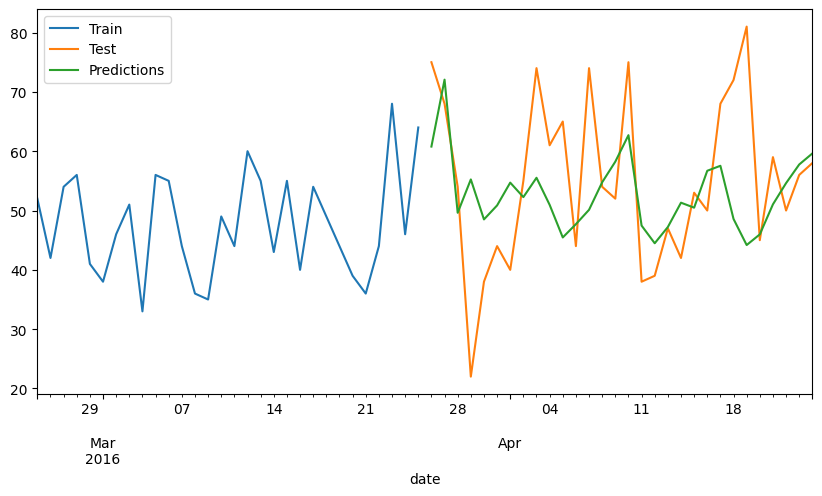

In [74]:
fig, ax = plt.subplots(figsize=(10, 5))
y_train[-30:].plot(ax=ax, label='Train')
y_test[-30:].plot(ax=ax, label='Test')
predictions.plot(ax=ax, label='Predictions')
ax.legend()
plt.show()